# <center>第八小组PageRank作业</center>


## 观察数据
#### 观察文件结构和说明，文件名为有向图的点列，文件结构为有向图的Outbound Edge

In [1]:
import os
with open('Pagerankdata/Demo10/1', "r",encoding='utf-8') as f:  val_list = f.read().splitlines()
print(val_list)

['1', '7', '10']


## 生成有向图(使用Demo10数据)

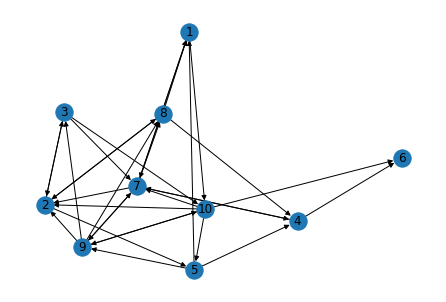

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

def dg_from_file(path,N):
    G = nx.DiGraph()
    files = os.listdir(path)
    for i in range (1,N+1):
        G.add_node(i)
    for file in files: 
        G.add_node(int(file))
        position = path+'/'+ file 
        with open(position, "r",encoding='utf-8') as f:  
            val_list = f.read().splitlines()
        #print(file)
        #print(val_list)
        for i in val_list:
            #Fit nparray with "1" in case there's an outbound link
            G.add_edge(int(file),int(i))
            #print('('+str(int(file))+','+str(int(i))+')')
    return G

graph = dg_from_file('Pagerankdata/Demo10',10)
nx.draw(graph, with_labels=True)
plt.show()    

#### 根据观察有向图，数据(Demo10)中存在明显DeadEnd--6，且不能保证为DAG（无环有向图）


## 数据生成邻接矩阵和马尔科夫矩阵（使用Demo10数据）
#### 从文件中读取生成邻接矩阵G，并通过转置变换和加权从邻接矩阵变形为马尔科夫矩阵M
#### 输出G和M进行查验

In [10]:
import numpy as np
import pandas as pd

def transpose_norm(G, N):
    M = np.zeros((N, N))
    for i in range(N):
        # set div for weighting inbound link
        div = sum(G[i])
        if div == 0:
            continue
        for j in range(N):
            # transpose the matrix to make outbound to inbound
            M[j][i] = G[i][j] / div 
    return M

def adjacency_from_file(path,N):
    # Initialization of Adjacency Matrix for N*N
    G = np.zeros((N,N))
    # Import file in batch
    files = os.listdir(path) 
    for file in files: 
        position = path+'/'+ file 
        with open(position, "r",encoding='utf-8') as f:  
            val_list = f.read().splitlines()
        #print(file)
        for i in val_list:
            #Fit nparray with "1" in case there's an outbound link
            G[int(file)-1][int(i)-1] = 1
    return G

N = 10
path = 'Pagerankdata/Demo' + str(N)
# data init from files
G = adjacency_from_file(path,N)
M = transpose_norm(G,N)
print(G)
print(M)

[[1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1. 1. 0.]
 [1. 1. 0. 1. 0. 0. 0. 1. 0. 0.]
 [0. 1. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 0. 1. 1. 1. 0. 1. 1.]]
[[0.33333333 0.         0.         0.         0.33333333 0.
  0.2        0.25       0.         0.        ]
 [0.         0.         0.25       0.         0.         0.
  0.2        0.25       0.2        0.16666667]
 [0.         0.33333333 0.25       0.         0.         0.
  0.         0.         0.2        0.        ]
 [0.         0.         0.         0.         0.33333333 0.
  0.2        0.25       0.         0.        ]
 [0.         0.33333333 0.         0.         0.         0.
  0.         0.         0.         0.16666667]
 [0.         0.         0.         0.5        0.         0.
  0.         0.         0.         0.16666667]
 [0.33333333 0.         0.2

## PageRank算法公式($\beta$为阻尼系数)

#### 根据 https://en.wikipedia.org/wiki/PageRank ,PageRank有2个略有不同的公式
#### $ PR(p_{i}) = (1 - \beta) + \beta \sum_{p_{j} \in M_{p_{i}}} \frac{PR(p_{j})}{L(p_{j})} $
#### 或
#### $ PR(p_{i}) = \frac{(1 - \beta)}{N} + \beta \sum_{p_{j} \in M_{p_{i}}} \frac{PR(p_{j})}{L(p_{j})} $

#### 主要区别在于马尔科夫矩阵经过计算后,选择与$[\frac{1}{N},\frac{1}{N},\frac{1}{N}.....\frac{1}{N}]$<sup>T</sup> 或 [1,1,1,1,1...1]<sup>T</sup> 的加权求和
#### $\color{red}{在Demo中的Excel里采用了第1公式作为计算}$，使用了[1,1,1,1,1...1]<sup>T</sup>
#### 增补公式2后，可见PageRank值之和收敛于1（使用公式1的sum值将收敛于N），两式的区别在于公式2每个页面的PageRank值为公式1的$\frac{1}{N}$

![Avatar](Excel_Result.png)

#### 编写pageRank计算函数，使用eps和最大迭代数T避免死锁，teleport用不同模式选择公式

In [6]:
def pageRank(M, N, T=3000, eps=1e-8, beta=.85, mode=1):
    R = np.ones(N)
    teleport = np.ones(N)
    if mode == 2:
        teleport /= N
    for time in range(T):
        # Introduce beta as a possibility to avoid sink of PR
        # if there's an deadend or spidertrap
        R_new = beta * np.dot(M, R) + (1-beta)*teleport
        if np.linalg.norm(R_new - R) < eps:
            break
        R = R_new.copy()
        #print(R.sum())
    return R_new

## 验证pageRank函数（手动生成与Demo Excel中相同的数据集Demo3）
#### 根据Excel输入条件生成邻接矩阵 (在Excel计算中输入的beta系数为0.5)

In [7]:
N = 3
path = 'Pagerankdata/Demo' + str(N)
# data init from files
G = adjacency_from_file(path,N)
print('邻接矩阵 G:')
print(G)
M = transpose_norm(G,N)
print('马尔科夫矩阵 M:')
print(M)
# set a maximum of iteration on calculate
values = pageRank(M,N,T=3000, beta=0.5)
#print(values.sum())
values_2 = pageRank(M,N,T=3000, beta=0.5, mode=2)

output = pd.DataFrame({'PageRank_Mode_1':values,'PageRank_Mode_2':values_2})
#Reset index of output to start from 1, align with input files
output.index = np.arange(1, len(output)+1)
print(output)

邻接矩阵 G:
[[0. 1. 1.]
 [0. 0. 1.]
 [1. 0. 0.]]
马尔科夫矩阵 M:
[[0.  0.  1. ]
 [0.5 0.  0. ]
 [0.5 1.  0. ]]
   PageRank_Mode_1  PageRank_Mode_2
1         1.076923         0.358974
2         0.769231         0.256410
3         1.153846         0.384615


# $\color{red}{结果相同}$


## 遍历给定数据集合{3,10,100,1000,10000}输出结果及统计信息
### 阻尼系数按照$\color{red}{\beta=0.85}$计算

PageRank Statistics For DEMO3


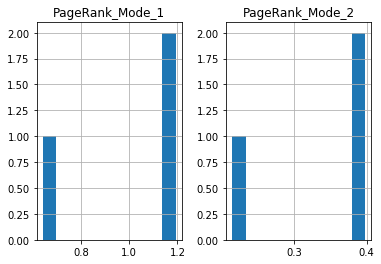

       PageRank_Mode_1  PageRank_Mode_2
count         3.000000         3.000000
mean          1.000000         0.333333
std           0.308268         0.102756
min           0.644432         0.214811
25%           0.903901         0.301300
50%           1.163369         0.387790
75%           1.177784         0.392595
max           1.192199         0.397400
PageRank Statistics For DEMO10


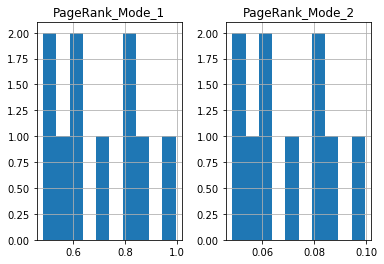

       PageRank_Mode_1  PageRank_Mode_2
count        10.000000        10.000000
mean          0.704693         0.070469
std           0.170097         0.017010
min           0.485379         0.048538
25%           0.571255         0.057126
50%           0.678760         0.067876
75%           0.821005         0.082100
max           0.994631         0.099463
PageRank Statistics For DEMO100


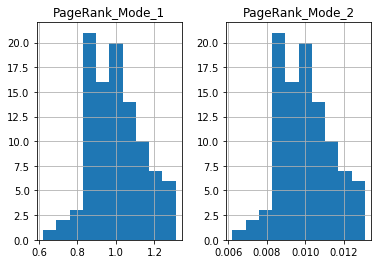

       PageRank_Mode_1  PageRank_Mode_2
count       100.000000       100.000000
mean          1.000000         0.010000
std           0.138959         0.001390
min           0.621729         0.006217
25%           0.893510         0.008935
50%           0.986033         0.009860
75%           1.085096         0.010851
max           1.309776         0.013098
PageRank Statistics For DEMO1000


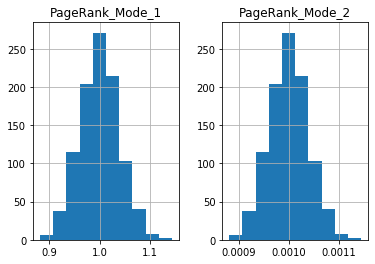

       PageRank_Mode_1  PageRank_Mode_2
count      1000.000000      1000.000000
mean          1.000000         0.001000
std           0.038983         0.000039
min           0.880894         0.000881
25%           0.973364         0.000973
50%           1.000451         0.001000
75%           1.025081         0.001025
max           1.144859         0.001145
PageRank Statistics For DEMO10000


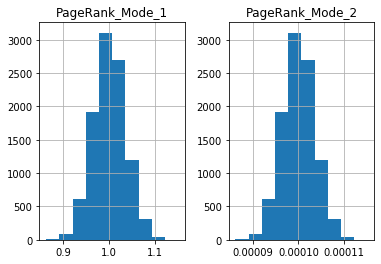

       PageRank_Mode_1  PageRank_Mode_2
count     10000.000000     10000.000000
mean          1.000000         0.000100
std           0.035372         0.000004
min           0.862308         0.000086
25%           0.975866         0.000098
50%           0.999788         0.000100
75%           1.023353         0.000102
max           1.150722         0.000115


In [9]:
instances =[3,10,100,1000,10000]
for N in instances:
    path = 'Pagerankdata/Demo' + str(N)
    # data init from files
    G = adjacency_from_file(path,N)
    M = transpose_norm(G,N)
    # set a maximum of iteration on calculate
    values = pageRank(M,N,T=3000, beta=.85)
    values_2 = pageRank(M,N,T=3000, beta=.85, mode=2)
    output = pd.DataFrame({'PageRank_Mode_1':values,'PageRank_Mode_2':values_2})
    #Reset index of output to start from 1, align with input files
    output.index = np.arange(1, len(output)+1)
    output.to_csv('output_'+str(N)+'.csv')
    print('PageRank Statistics For DEMO'+str(N))
    output.hist()
    plt.show()
    print(output.describe())